####**Load Data**

In [1]:
# Install required packages
!pip install datasets --quiet

In [2]:
# Find Colab environment
import os

colab_env = os.environ.get('GOOGLE_CLOUD_PROJECT')
if colab_env == None:
    print("Using Colab Research")
else:
    print("Using Colab Enterprise")

Using Colab Enterprise


In [3]:
# Login to Hugging Face
from huggingface_hub import login

if colab_env == None:
    # Get access token from Hugging Face hub
    from google.colab import userdata

    HF_TOKEN = userdata.get('HF_TOKEN')
else:
    # Get access token from Secret Manager
    !pip install google-cloud-secret-manager --quiet
    from google.cloud import secretmanager

    client = secretmanager.SecretManagerServiceClient()
    project_id = !gcloud config get-value project
    secret_name = f"projects/{project_id[0]}/secrets/HF_TOKEN/versions/latest"
    response = client.access_secret_version(request={"name": secret_name})
    HF_TOKEN = response.payload.data.decode("UTF-8")

if HF_TOKEN:
    login(HF_TOKEN)
    print("Successfully logged in to Hugging Face!")
else:
    print("Token is not set. Please set the token first.")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 218.1/218.1 kB 4.0 MB/s eta 0:00:00
Successfully logged in to Hugging Face!


In [4]:
# Load Hugging Face tokenized dataset dict anjan-k/Sentiment-Analysis-Tokenized
from datasets import load_dataset

sentiment_analysis_tokenized = load_dataset("anjan-k/Sentiment-Analysis-Tokenized")
print("Tokenized sentiment analysis dataset dict:")
print(sentiment_analysis_tokenized)

README.md:   0%|          | 0.00/670 [00:00<?, ?B/s]

data/train-00000-of-00001.parquet:   0%|          | 0.00/4.34M [00:00<?, ?B/s]

data/validation-00000-of-00001.parquet:   0%|          | 0.00/737k [00:00<?, ?B/s]

data/test-00000-of-00001.parquet:   0%|          | 0.00/720k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/31232 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/5205 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/5206 [00:00<?, ? examples/s]

Tokenized sentiment analysis dataset dict:
DatasetDict({
    train: Dataset({
        features: ['id', 'text', 'label', 'sentiment', 'input_ids', 'attention_mask'],
        num_rows: 31232
    })
    validation: Dataset({
        features: ['id', 'text', 'label', 'sentiment', 'input_ids', 'attention_mask'],
        num_rows: 5205
    })
    test: Dataset({
        features: ['id', 'text', 'label', 'sentiment', 'input_ids', 'attention_mask'],
        num_rows: 5206
    })
})


In [5]:
# Get tokenized test dataset
tokenized_test = sentiment_analysis_tokenized["test"]

In [ ]:
# Load model and tokenizer
from transformers import AutoTokenizer, AutoModelForSequenceClassification

model_name = "anjan-k/Sentiment-Analysis-FineTune-HuggingFace"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

In [7]:
# Use a data_collator to convert training samples to PyTorch tensors
from transformers import DataCollatorWithPadding
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [8]:
import torch
from torch.utils.data import DataLoader

# Set batch size
batch_size = 16

# Convert tokenized dataset to PyTorch tensors format
tokenized_test.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])

# Setup dataloaders
dataloader_test = DataLoader(tokenized_test, batch_size=batch_size, collate_fn=data_collator)

In [10]:
# Evaluate the model and report accuracy and f1-score

import torch
from sklearn.metrics import accuracy_score, f1_score

# Use GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

model.eval()
y_true = []
y_pred = []

# Evaluate loop
with torch.no_grad():
    for batch in dataloader_test:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        preds = torch.argmax(logits, dim=1)

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

In [13]:
from sklearn.metrics import classification_report

# Generate a Classification Report
labels = ["negative", "neutral", "positive"]
print("Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=labels))


Classification Report:

              precision    recall  f1-score   support

    negative       0.79      0.74      0.76      1546
     neutral       0.70      0.72      0.71      1930
    positive       0.82      0.83      0.83      1730

    accuracy                           0.76      5206
   macro avg       0.77      0.76      0.77      5206
weighted avg       0.76      0.76      0.76      5206



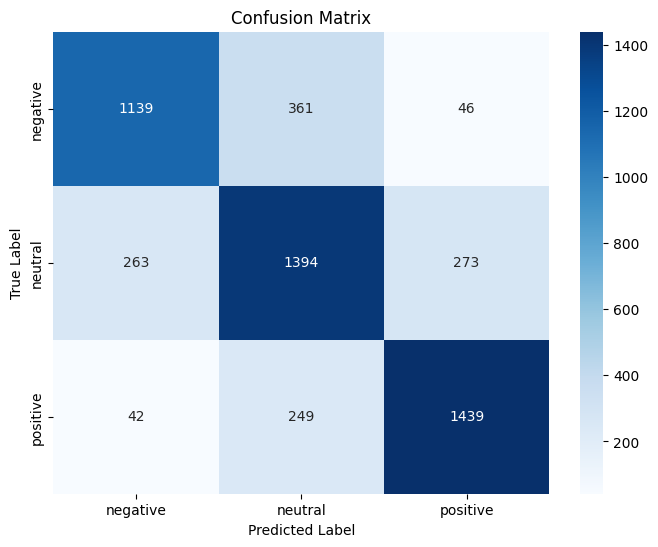

In [18]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Create a confusion matrix
cm = confusion_matrix(y_true, y_pred)
labels = ["negative", "neutral", "positive"]

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

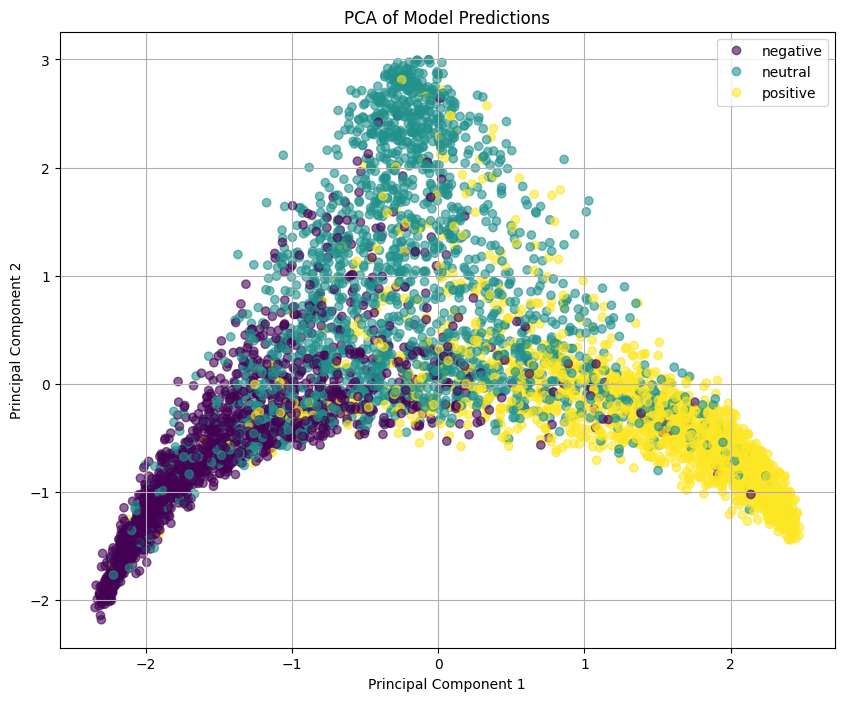

In [21]:
# Generate PCA chart
import torch
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Get the model's output logits for the test set
all_logits = []
model.eval()
with torch.no_grad():
    for batch in dataloader_test:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        all_logits.append(outputs.logits.cpu())

embeddings = torch.cat(all_logits).numpy()

# Scale the embeddings
scaler = StandardScaler()
scaled_embeddings = scaler.fit_transform(embeddings)

# Apply PCA for dimensionality reduction to 2 components for visualization
pca = PCA(n_components=2)
pca_embeddings = pca.fit_transform(scaled_embeddings)

# Get the true labels
true_labels = tokenized_test["label"]

# Visualize the PCA results
plt.figure(figsize=(10, 8))
scatter = plt.scatter(pca_embeddings[:, 0], pca_embeddings[:, 1], c=true_labels, cmap='viridis', alpha=0.6)
plt.title('PCA of Model Predictions')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(handles=scatter.legend_elements()[0], labels=labels)
plt.grid(True)
plt.show()

/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


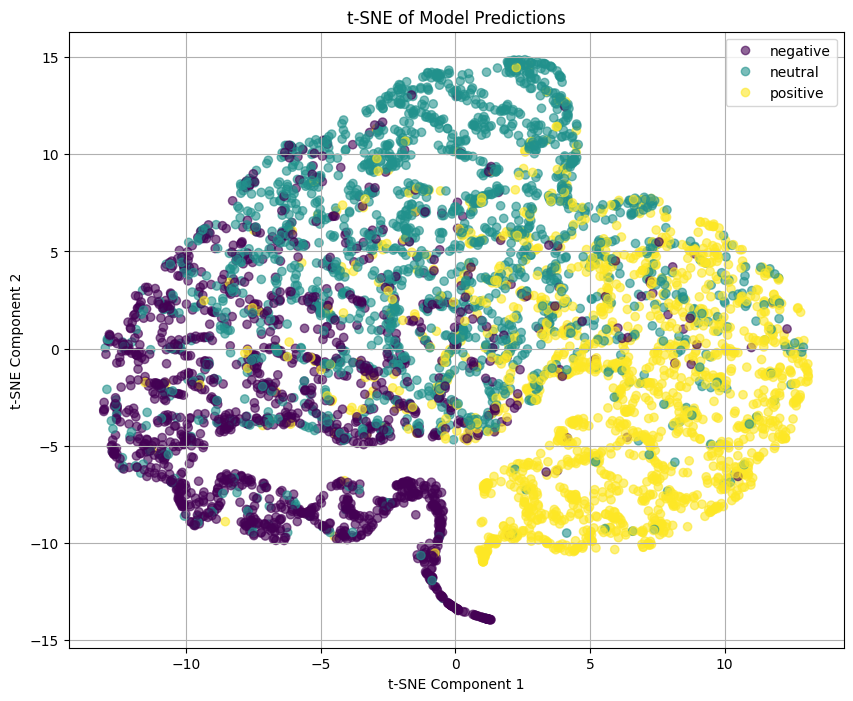

In [22]:
# Generate t-SNE chart

import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

# Get the model's output logits for the test set
all_logits = []
model.eval()
with torch.no_grad():
    for batch in dataloader_test:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        all_logits.append(outputs.logits.cpu())

embeddings = torch.cat(all_logits).numpy()

# Scale the embeddings
scaler = StandardScaler()
scaled_embeddings = scaler.fit_transform(embeddings)

# Apply t-SNE for dimensionality reduction to 2 components for visualization
tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=300)
tsne_embeddings = tsne.fit_transform(scaled_embeddings)

# Get the true labels
true_labels = tokenized_test["label"]

# Visualize the t-SNE results
plt.figure(figsize=(10, 8))
scatter = plt.scatter(tsne_embeddings[:, 0], tsne_embeddings[:, 1], c=true_labels, cmap='viridis', alpha=0.6)
plt.title('t-SNE of Model Predictions')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.legend(handles=scatter.legend_elements()[0], labels=labels)
plt.grid(True)
plt.show()
